In [1]:

from collections import OrderedDict
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import numba

In [2]:
def fen_to_binary(fen):
    """
    Convert chess FEN notation to binary representation.

    Args:
        fen (str): FEN string in format like 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

    Returns:
        dict: Dictionary containing binary representations of different FEN components
    """
    # Split FEN into its components
    parts = fen.split()
    board_str, active_color, castling, en_passant, halfmove, fullmove = parts
    bin = []

    # Convert piece positions to binary
    piece_mapping = {
        'p': [0,0,0,0,0,1], 'P': [0,0,0,0,1,0],
        'n': [0,0,0,0,1,1], 'N': [0,0,0,1,0,0],
        'b': [0,0,0,1,0,1], 'B': [0,0,0,1,1,0],
        'r': [0,0,0,1,1,1], 'R': [0,0,1,0,0,0],
        'q': [0,0,1,0,0,1], 'Q': [0,0,1,0,1,0],
        'k': [0,0,1,0,1,1], 'K': [0,0,1,1,0,0],
        '.': [0,0,0,0,0,0]  # Empty square
    }

    # Process board position
    for c in board_str:
        if c.isdigit():
            bin.extend(piece_mapping['.'] * int(c))
        elif c != '/':
            bin.extend(piece_mapping[c])

    # Active color to binary (0 for white, 1 for black)
    if active_color == 'b':
      bin.append(1)
    else:
      bin.append(0)

    # Castling rights to binary
    if 'K' in castling:
      bin.append(1)
    else:
      bin.append(0)
    if 'Q' in castling:
      bin.append(1)
    else:
      bin.append(0)
    if 'k' in castling:
      bin.append(1)
    else:
      bin.append(0)
    if 'q' in castling:
      bin.append(1)
    else:
      bin.append(0)

    # En passant to binary
    if en_passant == '-':
        bin.extend([0] * 6)  # No en passant square
    else:
        file = ord(en_passant[0]) - ord('a')
        rank = 8 - int(en_passant[1])
        bin.extend([int(bit) for bit in format(file, '03b')])
        bin.extend([int(bit) for bit in format(rank, '03b')])

    return bin

In [3]:
def normalize_df_integers(df, column_name=None, target_min=-15, target_max=15):
    # Input validation
    if df.empty:
        raise ValueError("DataFrame cannot be empty")

    # If column_name not specified, use first column
    if column_name is None:
        column_name = df.columns[0]

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    try:
        # Convert values to integers (if they're in string format)
        numbers = df[column_name].astype(float)

        # Get current min and max of the data
        current_min = numbers.min()
        current_max = numbers.max()

        # Handle special case where all values are the same
        if current_min == current_max:
            # Set all values to target_max if positive or target_min if negative
            if current_min < 0:
                return pd.Series([target_min] * len(numbers))
            elif current_min > 0:
                return pd.Series([target_max] * len(numbers))
            else:
                return pd.Series([0.0] * len(numbers))

        # Calculate scale and shift for normalization to target range
        scale = (target_max - target_min) / (current_max - current_min)
        shift = target_min - current_min * scale

        # Apply normalization
        normalized_numbers = numbers * scale + shift

        return normalized_numbers

    except ValueError as e:
        raise ValueError("Invalid input: Column must contain valid integers or floats") from e

In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

df = pd.read_csv('chessData.csv')
#df = cudf.DataFrame.from_pandas(df)

In [5]:
# Filter df_limit to keep only records where eval starts with + or -
valid_mask = df['Evaluation'].str.startswith('+') | df['Evaluation'].str.startswith('-')
df = df[valid_mask].copy()

# Report number of removed records
removed_count = len(valid_mask) - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} record(s) with invalid evaluation format")

Removed 1451510 record(s) with invalid evaluation format


In [6]:
df['Evaluation'] = df['Evaluation'].str.replace('+', '', regex=False).astype(int)

In [7]:
df = df.loc[df['Evaluation'].between(-10000, 10000, inclusive='both')]
df['bound_evals'] = df['Evaluation'] / 100


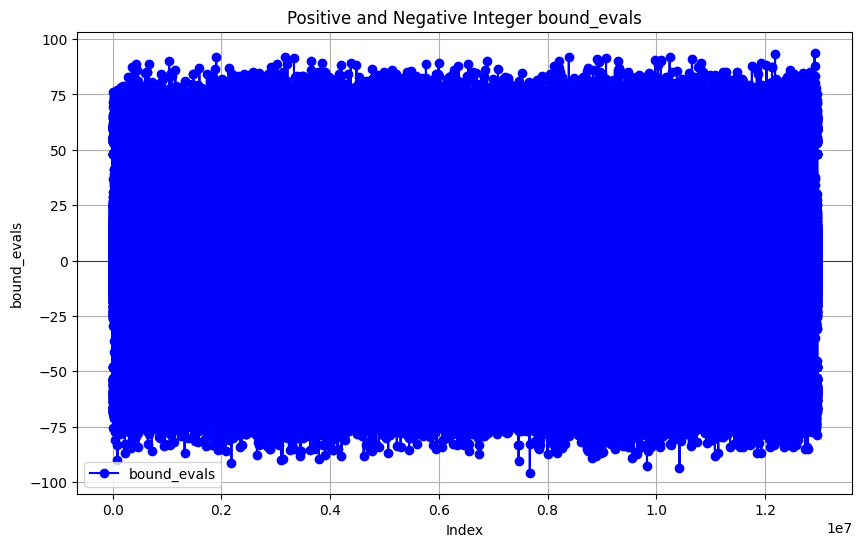

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['bound_evals'], marker='o', color='b', linestyle='-', label='bound_evals')  # Line plot
plt.axhline(0, color='black', linewidth=0.5)  # Zero line for reference
plt.xlabel('Index')
plt.ylabel('bound_evals')
plt.title('Positive and Negative Integer bound_evals')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
MAX = 1000000

df_limit = df.head(MAX)

chunk_size = 100000
df_chunks = [df_limit.loc[i:i + chunk_size] for i in range(0, MAX, chunk_size)]

df_chunk1 = df_chunks[0]
df_chunk2 = df_chunks[1]
df_chunk3 = df_chunks[2]
df_chunk4 = df_chunks[3]
df_chunk5 = df_chunks[4]
df_chunk6 = df_chunks[5]
df_chunk7 = df_chunks[6]
df_chunk8 = df_chunks[7]
df_chunk9 = df_chunks[8]
df_chunk10 = df_chunks[9]

In [10]:
df_chunk1['binary'] = df_chunk1['FEN'].apply(fen_to_binary)
#df_chunk1['bound_evals'] = normalize_df_integers(df=df_chunk1, column_name='Evaluation')

df_chunk2['binary'] = df_chunk2['FEN'].apply(fen_to_binary)
#df_chunk2['bound_evals'] = normalize_df_integers(df=df_chunk2, column_name='Evaluation')

df_chunk3['binary'] = df_chunk3['FEN'].apply(fen_to_binary)
#df_chunk3['bound_evals'] = normalize_df_integers(df=df_chunk3, column_name='Evaluation')

df_chunk4['binary'] = df_chunk4['FEN'].apply(fen_to_binary)
#df_chunk4['bound_evals'] = normalize_df_integers(df=df_chunk4, column_name='Evaluation')

df_chunk5['binary'] = df_chunk5['FEN'].apply(fen_to_binary)
#df_chunk5['bound_evals'] = normalize_df_integers(df=df_chunk5, column_name='Evaluation')

df_chunk6['binary'] = df_chunk6['FEN'].apply(fen_to_binary)
#df_chunk6['bound_evals'] = normalize_df_integers(df=df_chunk6, column_name='Evaluation')

df_chunk7['binary'] = df_chunk7['FEN'].apply(fen_to_binary)
#df_chunk7['bound_evals'] = normalize_df_integers(df=df_chunk7, column_name='Evaluation')

df_chunk8['binary'] = df_chunk8['FEN'].apply(fen_to_binary)
#df_chunk8['bound_evals'] = normalize_df_integers(df=df_chunk8, column_name='Evaluation')

df_chunk9['binary'] = df_chunk9['FEN'].apply(fen_to_binary)
#df_chunk9['bound_evals'] = normalize_df_integers(df=df_chunk9, column_name='Evaluation')

df_chunk10['binary'] = df_chunk10['FEN'].apply(fen_to_binary)
#df_chunk10['bound_evals'] = normalize_df_integers(df=df_chunk10, column_name='Evaluation')


<ipython-input-10-8122ea1eea0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk1['binary'] = df_chunk1['FEN'].apply(fen_to_binary)
<ipython-input-10-8122ea1eea0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk2['binary'] = df_chunk2['FEN'].apply(fen_to_binary)
<ipython-input-10-8122ea1eea0f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [11]:
df_limit = pd.concat(df_chunks, ignore_index=True)
df_limit

,FEN,Evaluation,bound_evals,binary
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10,-0.10,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,56,0.56,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9,-0.09,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,52,0.52,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26,-0.26,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
...,...,...,...,...
882594,1r3rk1/1q2ppb1/p2p1npp/1bpP4/2B4N/1P1QP2P/P4PP...,87,0.87,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
882595,1r3rk1/1q2ppb1/p2p1npp/1bpP4/2B2P1N/1P1QP2P/P5...,25,0.25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
882596,1r3rk1/1q2ppb1/p2p1npp/2pP4/2b2P1N/1P1QP2P/P5P...,105,1.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
882597,1r3rk1/1q2ppb1/p2p1npp/2pP4/2P2P1N/3QP2P/P5PB/...,40,0.40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."


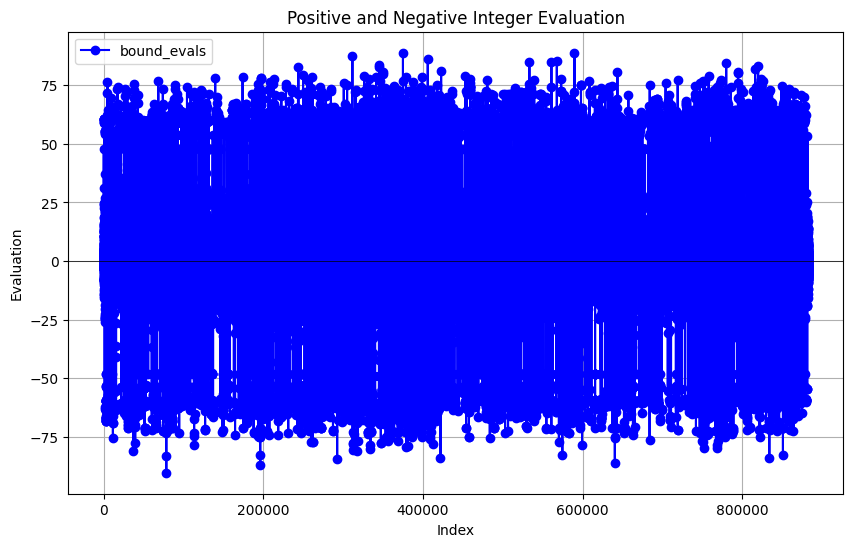

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_limit.index, df_limit['bound_evals'], marker='o', color='b', linestyle='-', label='bound_evals')  # Line plot
plt.axhline(0, color='black', linewidth=0.5)  # Zero line for reference
plt.xlabel('Index')
plt.ylabel('Evaluation')
plt.title('Positive and Negative Integer Evaluation')
plt.legend()
plt.grid(True)

plt.show()

In [35]:
X = df_limit['binary'].values
y = df_limit['bound_evals']

# Convert to PyTorch tensors
X_tensor =  torch.Tensor(list(X))
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(dim=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor,
    test_size=0.2,
    random_state=42
)

In [60]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=1000,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False
)

In [61]:
class ChessCNN(nn.Module):
    def __init__(self, learning_rate=1e-4, batch_size=1000, layer_count=10):
        super().__init__()

        layers = []
        for i in range(layer_count - 1):
            layers.append((f"linear-{i}", nn.Linear(395, 395)))
            layers.append((f"relu-{i}", nn.ReLU()))
        layers.append((f"linear-{layer_count-1}", nn.Linear(395, 1)))
        self.seq = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.seq(x)

In [62]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  chess_model.train()

  train_loss = 0

  for batch, (batch_X, batch_y) in enumerate(train_loader):
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      y_pred = chess_model(batch_X)
      loss = loss_fn(y_pred, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = loss

  return train_loss

In [63]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  model.eval()

  test_loss = 0

  with torch.inference_mode():
    for batch, (batch_X, batch_y) in enumerate(dataloader):
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      y_preds = chess_model(batch_X)

      y_loss = loss_fn(y_preds, batch_y)

      test_loss = y_loss

  return test_loss

In [64]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.L1Loss(),
          epochs: int = 10):

  results = {
      "train_loss": [],
      "test_loss": [],
  }

  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model=chess_model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer)

    test_loss = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} |"
      f"train_loss: {train_loss:.4f} |"
      f"test_loss: {test_loss:.4f} "
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

  return results

In [65]:
chess_model = ChessCNN().to(device)
chess_model

ChessCNN(
  (seq): Sequential(
    (linear-0): Linear(in_features=395, out_features=395, bias=True)
    (relu-0): ReLU()
    (linear-1): Linear(in_features=395, out_features=395, bias=True)
    (relu-1): ReLU()
    (linear-2): Linear(in_features=395, out_features=395, bias=True)
    (relu-2): ReLU()
    (linear-3): Linear(in_features=395, out_features=395, bias=True)
    (relu-3): ReLU()
    (linear-4): Linear(in_features=395, out_features=395, bias=True)
    (relu-4): ReLU()
    (linear-5): Linear(in_features=395, out_features=395, bias=True)
    (relu-5): ReLU()
    (linear-6): Linear(in_features=395, out_features=395, bias=True)
    (relu-6): ReLU()
    (linear-7): Linear(in_features=395, out_features=395, bias=True)
    (relu-7): ReLU()
    (linear-8): Linear(in_features=395, out_features=395, bias=True)
    (relu-8): ReLU()
    (linear-9): Linear(in_features=395, out_features=1, bias=True)
  )
)

In [66]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=chess_model.parameters(), lr=0.0001)

In [67]:
from timeit import default_timer as timer
start_time = timer()

NUM_EPOCHS = 150

chess_model_results = train(model=chess_model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "chess_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=chess_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

from google.colab import files
files.download(MODEL_SAVE_PATH)

print("less goooooo")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.5863 |test_loss: 2.1444 
Epoch: 2 |train_loss: 2.2058 |test_loss: 2.1049 
Epoch: 3 |train_loss: 2.0648 |test_loss: 2.0656 
Epoch: 4 |train_loss: 2.3780 |test_loss: 2.0336 
Epoch: 5 |train_loss: 2.0786 |test_loss: 2.0068 
Epoch: 6 |train_loss: 1.4807 |test_loss: 1.9986 
Epoch: 7 |train_loss: 2.1824 |test_loss: 1.9611 
Epoch: 8 |train_loss: 2.1007 |test_loss: 1.9572 
Epoch: 9 |train_loss: 1.1195 |test_loss: 1.9470 
Epoch: 10 |train_loss: 1.3049 |test_loss: 1.8722 
Epoch: 11 |train_loss: 1.3918 |test_loss: 1.9575 
Epoch: 12 |train_loss: 0.9360 |test_loss: 1.8549 
Epoch: 13 |train_loss: 1.8331 |test_loss: 1.9056 
Epoch: 14 |train_loss: 1.0275 |test_loss: 1.8979 
Epoch: 15 |train_loss: 1.7360 |test_loss: 1.8461 
Epoch: 16 |train_loss: 1.7694 |test_loss: 1.8404 
Epoch: 17 |train_loss: 1.7550 |test_loss: 1.8355 
Epoch: 18 |train_loss: 0.9953 |test_loss: 1.8361 
Epoch: 19 |train_loss: 1.2231 |test_loss: 1.8674 
Epoch: 20 |train_loss: 1.4270 |test_loss: 1.7635 
Epoch: 21

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

less goooooo
